
<h1 align="center">Аналитика данных. Домашнее задание 2.</h1>

<p align="center">Использование статистических тестов для анализа результатов теннисных матчей на практике.</p>

<p align="center">Подробное описание смотри в readme.md</p>


## План работы по каждой задаче

- Шаг 1: Подготовка данных
    - Загрузка данных
    - Предобработка датасетов (Пропуски и явные дубликаты)
  
- Шаг 2: Формулирование гипотез
    - Нулевая гипотеза
    - Альтернативная гипотеза

- Шаг 3: Определение характеристик выборки
    - Размер, среднее, дисперсия и тд

- Шаг 4: Определение подходящих тестов
    - Обоснование выбора теста
    - Проведение теста
    - Принятие или отклонение нулевой гипотезы

- Шаг 5: Формулирование выводов



In [165]:
# Импорты библиотек для проекта
import requests
#from bs4 import BeautifulSoup
import re

import os
import glob

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp # тест на нормальность распределения Колмогорова-Смирнова
from scipy.stats import shapiro # тест на нормальность распределения Шапиро
from scipy.stats import normaltest # тест на нормальность распределения Деагостино
from scipy.stats import mannwhitneyu # тест Манна-Уитни непараметрический тест
from scipy.stats import ttest_ind # t-тест
from statsmodels.stats.weightstats import ztest # z-тест
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

## Подготовка данных для всех задач

Все .csv файлы сложены в папку ./github_data

In [166]:
# Собираем данные из всех .csv файлы в единый датафрейм

# путь к папке с данными
folder_path = 'github_data'

# Получаем список всех csv файлов в папке с данными, соответствующих маске 'atp_matches_*.csv'
csv_files = glob.glob(os.path.join(folder_path, 'atp_matches_*.csv'))

# Читаем каждый csv файл и добавляем его в список датафреймов
df_list = [pd.read_csv(file) for file in csv_files]

# Объединяем все датафреймы в один, игнорируя индексы и используя внешнее объединение
combined_df = pd.concat(df_list, ignore_index=True, join='outer')

# Извлекаем год из столбца tourney_id, преобразуем его в целочисленный тип
combined_df['year'] = combined_df['tourney_id'].str.extract(
    r'(\d{4})').astype(int)

# Сохраняем датафрейм без индексов в csv файле, который будем использовать для решения задач
combined_df.to_csv('combined_atp_matches.csv', index=False)

In [167]:
# размерность датафрейма
combined_df.shape

(191920, 50)

## Используемые функции

In [168]:
def dataframe_summary(df):
    """
    Функция для исследования каждого DataFrame:
    - Количество строк и столбцов
    - Количество пропусков в каждом столбце
    - Количество явных дубликатов

    Параметры:
    df (DataFrame): Входной DataFrame.

    Возвращает:
    None: Функция выводит результаты на экран.
    """
    # Количество строк и столбцов
    num_rows, num_cols = df.shape
    print("Количество строк:", num_rows)
    print("Количество столбцов:", num_cols)

    # Количество пропусков в столбцах
    missing_values = df.isnull().sum()
    print("Количество пропусков в столбцах:")
    print(missing_values)

    # Количество явных дубликатов
    num_duplicates = df.duplicated().sum()
    print("Количество явных дубликатов:", num_duplicates)


In [169]:
def low_information_features(df):
    """
    Функция для определения неинформативных признаков в датафрейме.
    
    Признаки считаются неинформативными, если одно значение встречается более чем в 95%
    случаев или если более 95% значений являются уникальными.
    
    Args:
        df (pandas.DataFrame): Входной датафрейм.
        
    Returns:
        Union[list, str]: Список неинформативных признаков или сообщение об их отсутствии.
    """
    low_information_cols = []  # инициализация списка для неинформативных признаков

    for col in df.columns:  # цикл по всем столбцам
        # наибольшая относительная частота в признаке
        top_freq = df[col].value_counts(normalize=True).max()
        # доля уникальных значений от размера признака
        nunique_ratio = df[col].nunique() / df[col].count()

        # считаем признак неинформативным, если одно значение встречается более чем в 95% случаев
        if top_freq > 0.95:
            low_information_cols.append(col)  # добавляем столбец в список
            # выводим информацию о признаке
            print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')

        # считаем признак неинформативным, если более 95% значений являются уникальными
        elif nunique_ratio > 0.95:
            low_information_cols.append(col)  # добавляем столбец в список
            # выводим информацию о признаке
            print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

    # возвращаем список неинформативных признаков или сообщение об их отсутствии
    return low_information_cols if low_information_cols else "Нет неинформативных признаков"

In [170]:
def plot_missing_values(df):
    """
    Функция для построения столбчатой диаграммы, отображающей процент пропущенных значений в каждом столбце датафрейма.

    Параметры:
    df (DataFrame): Входной DataFrame.

    Возвращает:
    None: Функция выводит график на экран.
    """
    # Вычисляем процент пропущенных значений в каждом столбце
    missing_percentages = df.isnull().mean() * 100

    # Строим столбчатую диаграмму
    plt.figure(figsize=(10, 6))
    missing_percentages.plot(kind='bar', color='skyblue')
    plt.title('Процент пропущенных значений в каждом столбце')
    plt.xlabel('Столбцы')
    plt.ylabel('Процент пропущенных значений')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()


In [171]:
def plot_sample_data(sample_data_a, sample_data_b, title_a='a', title_b='b'):
    """
    Функция для создания гистограмм и boxplot для двух выборок.

    Args:
    sample_data_a: Первая выборка данных
    sample_data_b: Вторая выборка данных
    title_a: Название для первой выборки
    title_b: Название для второй выборки
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5)

    # Создание гистограммы для sample_data_a
    sns.histplot(sample_data_a, kde=True, ax=axs[0, 0])
    axs[0, 0].set_title(f'Гистограмма для {title_a}')

    # Создание гистограммы для sample_data_b
    sns.histplot(sample_data_b, kde=True, ax=axs[0, 1])
    axs[0, 1].set_title(f'Гистограмма для {title_b}')

    # Создание графика boxplot для sample_data_a с отрисовкой среднего и медианы
    sns.boxplot(sample_data_a,
                ax=axs[1, 0], showmeans=True, meanline=True, showfliers=False)
    axs[1, 0].set_title(
        f'Boxplot для {title_a} \n mean: {np.mean(sample_data_a):.2f}, median: {np.median(sample_data_a):.2f}')

    # Создание графика boxplot для sample_data_b с отрисовкой среднего и медианы
    sns.boxplot(sample_data_b,
                ax=axs[1, 1], showmeans=True, meanline=True, showfliers=False)
    axs[1, 1].set_title(
        f'Boxplot для {title_b} \n mean: {np.mean(sample_data_b):.2f}, median: {np.median(sample_data_b):.2f}')

    plt.show()

In [172]:
def shapiro_test(sample_a, sample_b, alpha=0.05):
    """
    Функция для тестирования нормальности распределения двух выборок методом Шапиро-Уилка.

    Параметры:
        - sample_a: первая выборка для тестирования
        - sample_b: вторая выборка для тестирования
        - alpha: уровень значимости (по умолчанию 0.05)

    Возвращает:
        - Результаты теста и вывод на экран

    """

    # Формулируем нулевую и альтернативную гипотезы
    H0 = 'Распределения в обеих группах нормальные'
    H1 = 'Распределение в одной или обеих группах отлично от нормального'

    # Проводим тест Шапиро-Уилка для каждой выборки
    shapiro_result_a = shapiro(sample_a)
    shapiro_result_b = shapiro(sample_b)

    # Вывод уровня значимости и p-value для каждой выборки
    print(f'alpha: {alpha}')
    print('p-value sample A', round(shapiro_result_a.pvalue, 2))
    print('p-value sample B', round(shapiro_result_b.pvalue, 2))

    # Вывод результатов
    if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
        print("Отвергаем нулевую гипотезу H0: {}".format(H0))
        print("Альтернативная гипотеза. H1: {}".format(H1))
    else:
        print("Принимаем нулевую гипотезу. {}".format(H0))

 ## Предобработка датасета

In [173]:
# выявляем неинформативные признаки
low_information_features(combined_df)

'Нет неинформативных признаков'

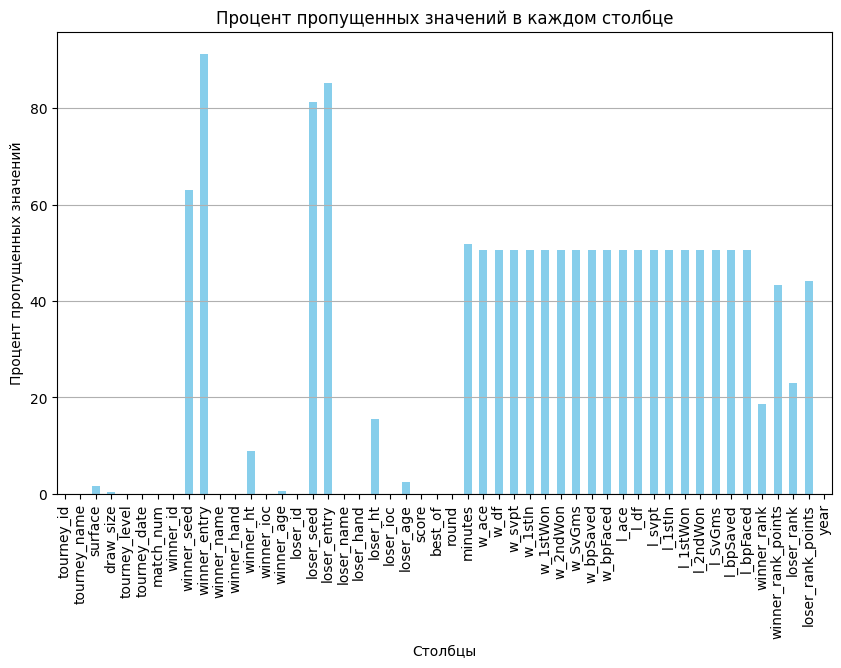

In [174]:
# процент пропущенных значений в каждом столбце датасета выводим в столбчатой диаграмме
plot_missing_values(combined_df)

In [175]:
# удаляем столбец если у него 60% или более значений отсутствует
combined_df = combined_df.dropna(axis=1, thresh=(0.4 * combined_df.shape[0]))

In [176]:
# выводим информацию о датасете после предобработки
dataframe_summary (combined_df)

Количество строк: 191920
Количество столбцов: 46
Количество пропусков в столбцах:
tourney_id                0
tourney_name              0
surface                2990
draw_size               835
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_name               0
winner_hand              12
winner_ht             16908
winner_ioc                8
winner_age             1311
loser_id                  0
loser_name                0
loser_hand               49
loser_ht              29663
loser_ioc                72
loser_age              4657
score                     9
best_of                   0
round                     0
minutes               99653
w_ace                 96885
w_df                  96886
w_svpt                96886
w_1stIn               96886
w_1stWon              96886
w_2ndWon              96886
w_SvGms               96885
w_bpSaved             96886
w_bpFaced             96886
l_ace                 

In [177]:
combined_df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1968-2029,Dublin,Grass,32.0,A,19680708,270,112411,Doug Smith,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
1,1968-2029,Dublin,Grass,32.0,A,19680708,271,126914,Louis Pretorius,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
2,1968-2029,Dublin,Grass,32.0,A,19680708,272,209523,Cecil Pedlow,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
3,1968-2029,Dublin,Grass,32.0,A,19680708,273,100084,Tom Okker,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
4,1968-2029,Dublin,Grass,32.0,A,19680708,274,100132,Armistead Neely,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968


## Задача 1a

>Проверьте следующие утверждения - Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);

Шаги решения:
* Сформировать две выборки игроков: первая выборка - игроки с рангом, отличающимся более чем на 20 позиций от противника, вторая - игроки с близким рангом к противнику (отличие менее 20 позиций). Например: 
`df_rank_1['higher_rank_win'] = (df_rank_1['winner_rank'] - df_rank_1['loser_rank']) > 20`
* Для каждой игры в выборках посчитать ожидаемое количество побед при случайном исходе. Это можно сделать, умножив количество сыгранных игр на вероятность выигрыша 0,5 (при равных шансах для каждого игрока).
* Посчитать фактическое количество побед для каждого игрока в выборках.
* Вычислить отклонение фактического количества побед от ожидаемого для каждого игрока.
* Рассчитать среднее отклонение для каждой выборки.
* Сравнить средние отклонения между выборками. Если в первой выборке (ранг выше более чем на 20 позиций) среднее отклонение значительно выше, чем во второй выборке, то это подтверждает гипотезу о большей вероятности выигрыша у игроков с более высоким рангом.

In [178]:
# Создание выборки для решения задачи
combined_df = pd.read_csv('combined_atp_matches.csv')
task_01_a = combined_df[['year', 'match_num', 'winner_id',
                         'winner_rank', 'loser_id', 'loser_rank']].dropna()
task_01_a['rank_diff_more20'] = np.where(
    abs(task_01_a['winner_rank'] - task_01_a['loser_rank']) > 20, 1, 0)

# Размеры выборок
task_01_a.rank_diff_more20.value_counts()

rank_diff_more20
1    106767
0     37093
Name: count, dtype: int64

In [179]:
dataframe_summary(task_01_a)
task_01_a.head()

Количество строк: 143860
Количество столбцов: 7
Количество пропусков в столбцах:
year                0
match_num           0
winner_id           0
winner_rank         0
loser_id            0
loser_rank          0
rank_diff_more20    0
dtype: int64
Количество явных дубликатов: 57


,year,match_num,winner_id,winner_rank,loser_id,loser_rank,rank_diff_more20
18086,1973,1,100119,1.0,100129,88.0,1
18087,1973,2,100304,193.0,100067,71.0,1
18088,1973,3,100135,39.0,100376,118.0,1
18089,1973,4,100121,42.0,100075,135.0,1
18090,1973,5,100284,4.0,100058,11.0,0


In [180]:
def calculate_player_performance_metrics(task_01_a):
   """
   Функция для расчёта метрик производительности игроков

   Parameters:
   task_01_a (DataFrame): DataFrame с информацией о победах и поражениях

   Returns:
   DataFrame: DataFrame с метриками производительности игроков
   """
   wins_count = task_01_a['winner_id'].value_counts()
   losses_count = task_01_a['loser_id'].value_counts()
   total_games = wins_count.add(losses_count, fill_value=0).astype(int)
   player_performance_df = pd.DataFrame({
       'player_id': total_games.index,
       'wins': wins_count,
       'losses': losses_count,
       'total': total_games
   }).reset_index(drop=True)
   player_performance_df['wins'].fillna(0, inplace=True)
   player_performance_df['losses'].fillna(0, inplace=True)
   player_performance_df['wins'] = player_performance_df['wins'].astype(int)
   player_performance_df['losses'] = player_performance_df['losses'].astype(
       int)
   player_performance_df['expected_wins'] = player_performance_df['total'] * 0.5
   player_performance_df['deviation'] = player_performance_df['wins'] - \
       player_performance_df['expected_wins']
   return player_performance_df.sort_values(by='total', ascending=False)

In [181]:
more20 = calculate_player_performance_metrics(task_01_a[task_01_a['rank_diff_more20'] == 1])
less20 = calculate_player_performance_metrics(task_01_a[task_01_a['rank_diff_more20'] == 0])

In [182]:
more20.head()

,player_id,wins,losses,total,expected_wins,deviation
2028,103819,821,103,924,462.0,359.0
2397,104745,694,88,782,391.0,303.0
1150,101736,614,132,746,373.0,241.0
2461,104925,661,73,734,367.0,294.0
469,100656,626,86,712,356.0,270.0


In [183]:
less20.head()

,player_id,wins,losses,total,expected_wins,deviation
1157,103819,441,177,618,309.0,132.0
1330,104925,437,141,578,289.0,148.0
1306,104745,385,139,524,262.0,123.0
350,100656,325,145,470,235.0,90.0
176,100284,277,138,415,207.5,69.5


In [184]:
# Рассчитать среднее отклонение для каждой выборки
mean_dev_more20 = more20.deviation.abs().mean()
mean_dev_less20 = less20.deviation.abs().mean()

print(f'Cреднее отклонение для выборки more20: {round(mean_dev_more20, 2)}')
print(f'Cреднее отклонение для выборки less20: {round(mean_dev_less20, 2)}')


# Если в первой выборке (ранг выше более чем на 20 позиций) среднее отклонение значительно выше,
# чем во второй выборке, то это подтверждает гипотезу о
# большей вероятности выигрыша у игроков с более высоким рангом.

Cреднее отклонение для выборки more20: 7.23
Cреднее отклонение для выборки less20: 2.97


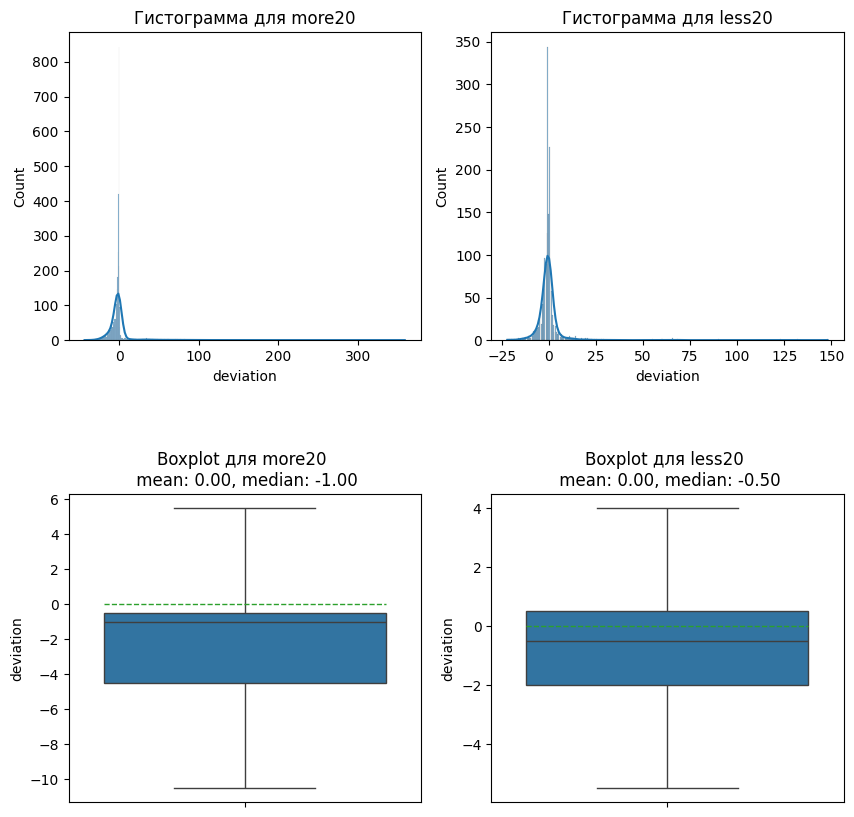

In [185]:
plot_sample_data(more20.deviation, less20.deviation, title_a='more20', title_b='less20')

### Выбор теста Шапиро-Уилка

Если две выборки выделены из одной изначальной выборки, то эти две выборки будут связанными или зависимыми. Для оценки нормальности распределения я останавливаюсь на тесте Шапиро(Шапиро-Уилка), он является одним из наиболее чувствительных тестов на нормальность, не требует предварительных предположений о параметрах распределения или типе данных. Он может быть использован как для непрерывных, так и для дискретных данных (как в нашем случае).

In [186]:
# Статистический тест на нормальность

shapiro_test (more20.deviation, less20.deviation, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


#### Выбор теста Мана-Уитни
Нулевая гипотеза (H0): 
Нет статистически значимой разницы в медианах отклонений между двумя независимыми выборками. 
Это означает, что любые различия между выборками могут быть результатом случайности.

Альтернативная гипотеза (H1): 
Существует статистически значимая разница в медианах отклонений между двумя независимыми выборками. 
Это указывает на то, что наблюдаемые различия маловероятно являются случайными и что 
одна из групп имеет тенденцию к более высоким или низким отклонениям.

выбора параметра alternative:

* 'two-sided' используется, если вы хотите проверить, отличаются ли выборки вообще (в любом направлении).
* 'less' используется, если вы предполагаете, что медиана первой выборки меньше медианы второй.
* 'greater' используется, если вы предполагаете, что медиана первой выборки больше медианы второй.

In [187]:
# Тест Мана-Уитни
sample_a = more20.deviation
sample_b = less20.deviation

# Уровень значимости
alpha = 0.05

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(sample_a, sample_b, alternative='greater')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Формулировка гипотез
H0 = 'Среднее отклонений для more20 не больше медианы для выборки less20'
H1 = 'Среднее отклонений для more20 больше медианы для выборки less20'
print(
    f'Нулевая гипотеза (вероятность победы не выше в группе с разницей рангов >20):{H0}')
print(
    f'Альтернативная гипотеза (вероятность победы выше в группе с разницей рангов >20):{H1}')

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0} при a = {alpha}.')
    print(f'Принимаем альтернативную гипотезу: {H1} при a = {alpha}.')
else:
    print(f'Не отвергаем нулевую гипотезу: {H0} при a = {alpha}.')

U-статистика: 2221913.5
p-значение: 1.0
Нулевая гипотеза (вероятность победы не выше в группе с разницей рангов >20):Среднее отклонений для more20 не больше медианы для выборки less20
Альтернативная гипотеза (вероятность победы выше в группе с разницей рангов >20):Среднее отклонений для more20 больше медианы для выборки less20
Не отвергаем нулевую гипотезу: Среднее отклонений для more20 не больше медианы для выборки less20 при a = 0.05.


### Вывод

* Не отвергаем нулевую гипотезу: ***Нет статистически значимой разницы в медианах отклонений между этими двумя независимыми выборками***

***

### Задача 1б

>Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

Задача аналогична 1а, но нужно сделать выборку для случая различия рангов на 5 позиций и сравнить среднее количество побед между двумя группами.

In [188]:
# Считываем данные, создаем датафрейм, удаляем пропуски
combined_df = pd.read_csv('combined_atp_matches.csv')
task_01_b = combined_df[['year', 'match_num', 'winner_id',
                         'winner_rank', 'loser_id', 'loser_rank']].dropna()

# Создание бинарного признака window5, указывающего,
# попадает ли разница рангов в интервал [-5, 5]
task_01_b['window5'] = task_01_b.apply(
    lambda row: 'in' if 
    -5 <= (row['winner_rank'] - row['loser_rank']) <= 5 else 'out',
    axis=1)

# подсчет вхождений
task_01_b.window5.value_counts()

window5
out    133840
in      10020
Name: count, dtype: int64

In [189]:
dataframe_summary(task_01_b)

Количество строк: 143860
Количество столбцов: 7
Количество пропусков в столбцах:
year           0
match_num      0
winner_id      0
winner_rank    0
loser_id       0
loser_rank     0
window5        0
dtype: int64
Количество явных дубликатов: 57


In [190]:
task_01_b.head()

,year,match_num,winner_id,winner_rank,loser_id,loser_rank,window5
18086,1973,1,100119,1.0,100129,88.0,out
18087,1973,2,100304,193.0,100067,71.0,out
18088,1973,3,100135,39.0,100376,118.0,out
18089,1973,4,100121,42.0,100075,135.0,out
18090,1973,5,100284,4.0,100058,11.0,out


In [191]:
# Фильтрация записей с 1980 по 2022 год
filtered_df = task_01_b[(task_01_b['year'] >= 1984) &
                        (task_01_b['year'] <= 2022)]

# Группировка по 'winner_id', 'year' и 'window5', подсчет количества побед
win_counts = filtered_df.groupby(
    ['winner_id', 'year', 'window5']).size().reset_index(name='win_count')

# Считаем среднее количество побед
average_wins = win_counts.groupby(['year', 'window5'])[
    'win_count'].mean().reset_index()

# Разделение среднего количества побед на группы 'in' и 'out'
average_wins_in = average_wins[average_wins['window5'] == 'in'].reset_index(
    drop=True)
average_wins_out = average_wins[average_wins['window5'] == 'out'].reset_index(
    drop=True)

In [192]:
win_counts.head(20)

,winner_id,year,window5,win_count
0,100119,1985,out,1
1,100144,1984,out,1
2,100144,1985,out,1
3,100179,1984,out,2
4,100179,1985,out,1
5,100221,1986,out,2
6,100240,1984,out,3
7,100240,1985,out,4
8,100240,1986,out,3
9,100244,1984,in,1


In [193]:
dataframe_summary(average_wins_in)
average_wins_in.head()

Количество строк: 39
Количество столбцов: 3
Количество пропусков в столбцах:
year         0
window5      0
win_count    0
dtype: int64
Количество явных дубликатов: 0


,year,window5,win_count
0,1984,in,1.873563
1,1985,in,1.966292
2,1986,in,2.144330
3,1987,in,1.938776
4,1988,in,1.803738


In [194]:
dataframe_summary(average_wins_out)
average_wins_out.head()

Количество строк: 39
Количество столбцов: 3
Количество пропусков в столбцах:
year         0
window5      0
win_count    0
dtype: int64
Количество явных дубликатов: 0


,year,window5,win_count
0,1984,out,9.740000
1,1985,out,10.194719
2,1986,out,9.925170
3,1987,out,10.261146
4,1988,out,9.845930


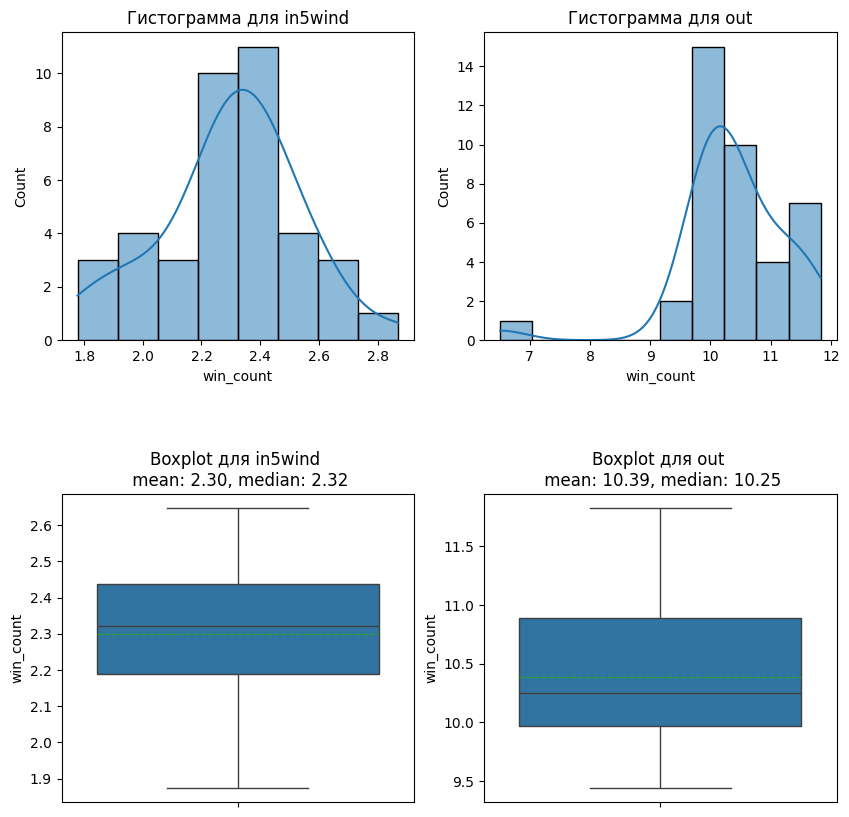

In [195]:
# Графическое представление распределений признака `win_count` для каждой выборки
plot_sample_data(average_wins_in.win_count,average_wins_out.win_count, title_a='in5wind', title_b='out')

In [196]:
# Статистический тест на нормальность, используем Шапиро-Уилка
shapiro_test(average_wins_in.win_count, average_wins_out.win_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.57
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [197]:
# Среднее количество побед в группе in5window
average_wins_in.win_count.mean()

2.299102049249689

In [198]:
# Среднее количество побед в группе out
average_wins_out.win_count.mean()

10.389651533600555

Статистический критерий.
Тест Манна-Уитни (U-тест)` выбран для сравнения средних значений выборок, так как он подходит для независимых выборок небольшого размера и не предполагает нормальное распределение данных. Также, он позволяет провести одностороннюю проверку гипотезы о том, что среднее значение в одной выборке больше среднего значения в другой выборке.

In [199]:
# Формулировка гипотез
H0 = 'Среднее количество побед в группе out не больше среднего в группе in'
H1 = 'Среднее количество побед в группе out больше среднего в группе in'

# Уровень значимости
alpha = 0.05

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(average_wins_in.win_count,
                       average_wins_out.win_count, alternative='less')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0}')
    print(f'Принимаем альтернативную гипотезу: {H1}')
else:
    print(f'Принимаем нулевую гипотезу: {H0}')

U-статистика: 0.0
p-значение: 1.5393187778399125e-14
Отвергаем нулевую гипотезу: Среднее количество побед в группе out не больше среднего в группе in
Принимаем альтернативную гипотезу: Среднее количество побед в группе out больше среднего в группе in


#### Вывод

Если ранг игрока находится в окне +-5 позиций, то ***вероятность победы будет значительно отличаться (вероятность победы ниже)*** от гипотезы из предыдущего случая (там разницы нет).

***

## Задача 2

>Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

Для расчета количества сетов можно использовать признак `score`

In [200]:
# Считываем данные и оставляем нужные столбцы, убираем пропуски
combined_df = pd.read_csv('combined_atp_matches.csv')
task_02 = combined_df[['year', 'score', 'winner_id']].dropna()

# Создаем признак с количеством сетов
# Учитываем только те сеты при подсчете, где явно указан счет партии в сете
def count_sets_with_scores(score):
    sets = re.findall(r'\d+-\d+', score)
    return len(sets)


task_02['sets_count'] = task_02['score'].apply(count_sets_with_scores)

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_02['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_02[task_02['sets_count'] == count].head(1))

dataframe_summary(task_02)

Образец для количества сетов: 0


,year,score,winner_id,sets_count
129,1968,W/O,100099,0


Образец для количества сетов: 1


,year,score,winner_id,sets_count
67,1968,1-0 RET,109825,1


Образец для количества сетов: 2


,year,score,winner_id,sets_count
0,1968,6-1 7-5,112411,2


Образец для количества сетов: 3


,year,score,winner_id,sets_count
5,1968,4-6 8-6 6-2,207073,3


Образец для количества сетов: 4


,year,score,winner_id,sets_count
32,1968,6-3 6-2 0-6 6-3,100099,4


Образец для количества сетов: 5


,year,score,winner_id,sets_count
43,1968,6-0 2-6 6-3 4-6 7-5,100282,5


Количество строк: 191911
Количество столбцов: 4
Количество пропусков в столбцах:
year          0
score         0
winner_id     0
sets_count    0
dtype: int64
Количество явных дубликатов: 17938


In [201]:
# Удаление полных дубликатов
task_02 = task_02.drop_duplicates()

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_02['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_02[task_02['sets_count'] == count].head(1))

dataframe_summary(task_02)

Образец для количества сетов: 0


,year,score,winner_id,sets_count
129,1968,W/O,100099,0


Образец для количества сетов: 1


,year,score,winner_id,sets_count
67,1968,1-0 RET,109825,1


Образец для количества сетов: 2


,year,score,winner_id,sets_count
0,1968,6-1 7-5,112411,2


Образец для количества сетов: 3


,year,score,winner_id,sets_count
5,1968,4-6 8-6 6-2,207073,3


Образец для количества сетов: 4


,year,score,winner_id,sets_count
32,1968,6-3 6-2 0-6 6-3,100099,4


Образец для количества сетов: 5


,year,score,winner_id,sets_count
43,1968,6-0 2-6 6-3 4-6 7-5,100282,5


Количество строк: 173973
Количество столбцов: 4
Количество пропусков в столбцах:
year          0
score         0
winner_id     0
sets_count    0
dtype: int64
Количество явных дубликатов: 0


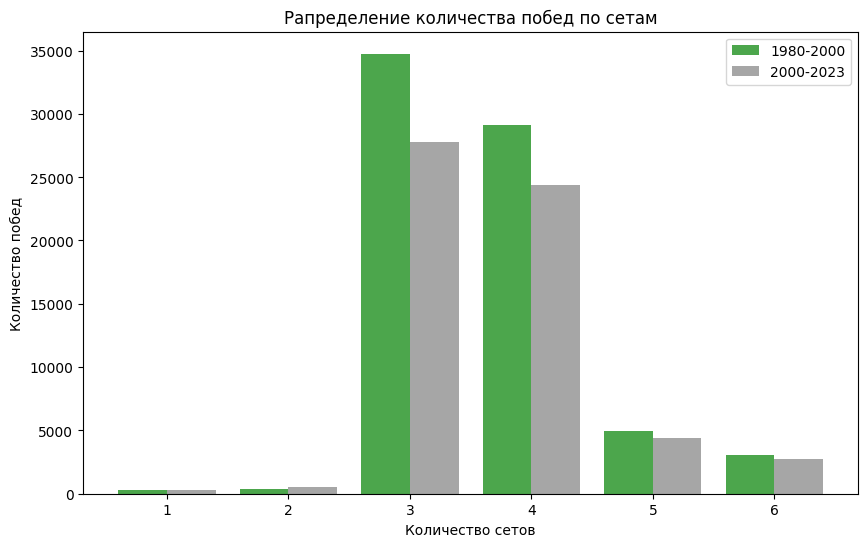

In [202]:
# Рапределение количества сетов, всего
# Фильтрация данных по годам
task_02_1980_2001 = task_02[(task_02['year'] >= 1980) & (task_02['year'] <= 2001)].reset_index(drop=True)
task_02_2002_2023 = task_02[(task_02['year'] > 2001) & (task_02['year'] <= 2023)].reset_index(drop=True)

# Создание позиций для баров
positions = range(1, max(task_02['sets_count']) + 2, 1)

# Построение гистограммы для каждой группы с разными цветами
plt.figure(figsize=(10, 6))
plt.bar([pos - 0.2 for pos in positions],
        task_02_1980_2001['sets_count'].value_counts().sort_index(),
        width=0.4,
        color='green',
        alpha=0.7,
        label='1980-2000')
plt.bar([pos + 0.2 for pos in positions],
        task_02_2002_2023['sets_count'].value_counts().sort_index(),
        width=0.4,
        color='gray',
        alpha=0.7,
        label='2000-2023')

plt.title('Рапределение количества побед по сетам')
plt.xlabel('Количество сетов')
plt.ylabel('Количество побед')
plt.legend()
plt.show()

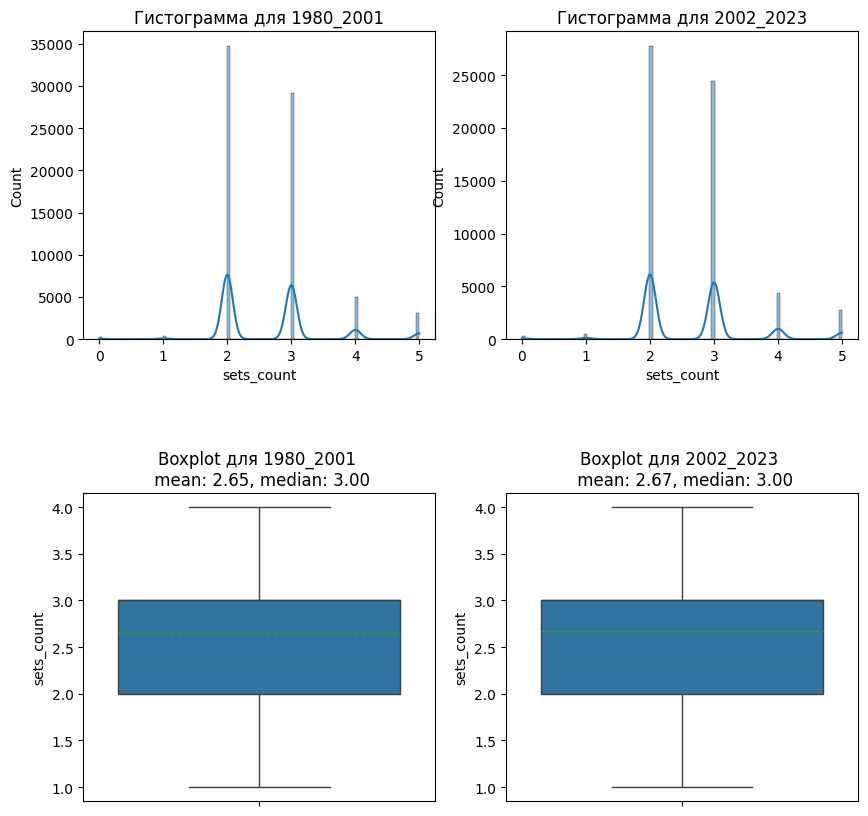

In [203]:
plot_sample_data(task_02_1980_2001.sets_count, task_02_2002_2023.sets_count,title_a='1980_2001', title_b='2002_2023')

In [204]:
# Сравнение среднего количества побед

print("Среднее количество сетов для побед в периоде 1980-2001: {:.4}, \
      общее количество партий: {}".format(task_02_1980_2001.sets_count.mean(), len(task_02_1980_2001.sets_count)))

print("Среднее количество сетов для побед в периоде 2002-2023: {:.4}, \
      общее количество партий: {}".format(task_02_2002_2023.sets_count.mean(), len(task_02_2002_2023.sets_count)))


Среднее количество сетов для побед в периоде 1980-2001: 2.653,       общее количество партий: 72558
Среднее количество сетов для побед в периоде 2002-2023: 2.669,       общее количество партий: 60151


In [205]:
# выполним тест на нормальность
shapiro_test(task_02_1980_2001.sets_count, task_02_2002_2023.sets_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [206]:
# Примененим z-test - данных достаточно (>>30), визуально данные не значительно отличаются от нормального распределения, выборки независимы
# используем alpha = 0.05
# Нулевая гипотеза: среднее значение выборки 1980_2001 меньше или равно среднему значению выборки 2002_2023
# Альтернативная гипотеза: среднее значение выборки 1980_2001 больше среднего значения выборки 2002_2023
t_statistic, p_value = ztest(
    task_02_1980_2001.sets_count, task_02_2002_2023.sets_count, alternative='larger')

# Вывод результатов
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Установим уровень значимости, например, 0.05
alpha = 0.05

# Проверим нулевую гипотезу
if p_value < alpha:
    print("Отвергаем нулевую гипотезу - среднее выборки 1980_2001 больше среднего выборки 2002_2023")
else:
    print("Не отвергаем нулевую гипотезу")

t-statistic: -3.4641509089513445
p-value: 0.999734045988888
Не отвергаем нулевую гипотезу


### Вывод

***Гипотеза, что среднее количество сетов необходимых для победы игрока уменьшается со временем - <u>не верна</u>.***

***

## Задача 3
>У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

Сформируем датасет:
1. Отфильтруем данные оставив только матчи с df['best_of'] == 5 
2. Разделим данные на две группы в зависимости от года матча. В первой группе будут матчи с 1980 по 2001 год, во второй с 2002 по 2022 год.

In [207]:
# Считываем данные и оставляем нужные столбцы, убираем пропуски
combined_df = pd.read_csv('combined_atp_matches.csv')
task_03 = combined_df[['year', 'score', 'winner_id', 'best_of']].dropna()
# оставляем только матчи best of 5
task_03 = task_03[task_03.best_of == 5]

# Создаем признак с количеством сетов
# Учитываем только те сеты при подсчете, где явно указан счет партии в сете
def count_sets_with_scores(score):
    sets = re.findall(r'\d+-\d+', score)
    return len(sets)


task_03['sets_count'] = task_03['score'].apply(count_sets_with_scores)

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_03['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_03[task_03['sets_count'] == count].head(1))

dataframe_summary(task_03)

Образец для количества сетов: 0


,year,score,winner_id,best_of,sets_count
233,1968,W/O,100085,5,0


Образец для количества сетов: 1


,year,score,winner_id,best_of,sets_count
9444,1970,2-1 RET,100203,5,1


Образец для количества сетов: 2


,year,score,winner_id,best_of,sets_count
101,1968,6-3 0-1 RET,110047,5,2


Образец для количества сетов: 3


,year,score,winner_id,best_of,sets_count
31,1968,6-1 6-4 6-4,100029,5,3


Образец для количества сетов: 4


,year,score,winner_id,best_of,sets_count
32,1968,6-3 6-2 0-6 6-3,100099,5,4


Образец для количества сетов: 5


,year,score,winner_id,best_of,sets_count
43,1968,6-0 2-6 6-3 4-6 7-5,100282,5,5


Количество строк: 42042
Количество столбцов: 5
Количество пропусков в столбцах:
year          0
score         0
winner_id     0
best_of       0
sets_count    0
dtype: int64
Количество явных дубликатов: 289


In [208]:
task_03.head()

,year,score,winner_id,best_of,sets_count
31,1968,6-1 6-4 6-4,100029,5,3
32,1968,6-3 6-2 0-6 6-3,100099,5,4
33,1968,11-9 9-11 6-4 6-3,100022,5,4
34,1968,6-1 4-6 10-8 6-3,100026,5,4
35,1968,6-2 8-6 6-2,100029,5,3


In [209]:
# Удаление полных дубликатов
task_03 = task_03.drop_duplicates()

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_03['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_03[task_03['sets_count'] == count].head(1))

dataframe_summary(task_03)

Образец для количества сетов: 0


,year,score,winner_id,best_of,sets_count
233,1968,W/O,100085,5,0


Образец для количества сетов: 1


,year,score,winner_id,best_of,sets_count
9444,1970,2-1 RET,100203,5,1


Образец для количества сетов: 2


,year,score,winner_id,best_of,sets_count
101,1968,6-3 0-1 RET,110047,5,2


Образец для количества сетов: 3


,year,score,winner_id,best_of,sets_count
31,1968,6-1 6-4 6-4,100029,5,3


Образец для количества сетов: 4


,year,score,winner_id,best_of,sets_count
32,1968,6-3 6-2 0-6 6-3,100099,5,4


Образец для количества сетов: 5


,year,score,winner_id,best_of,sets_count
43,1968,6-0 2-6 6-3 4-6 7-5,100282,5,5


Количество строк: 41753
Количество столбцов: 5
Количество пропусков в столбцах:
year          0
score         0
winner_id     0
best_of       0
sets_count    0
dtype: int64
Количество явных дубликатов: 0


In [210]:
task_03.head()

,year,score,winner_id,best_of,sets_count
31,1968,6-1 6-4 6-4,100029,5,3
32,1968,6-3 6-2 0-6 6-3,100099,5,4
33,1968,11-9 9-11 6-4 6-3,100022,5,4
34,1968,6-1 4-6 10-8 6-3,100026,5,4
35,1968,6-2 8-6 6-2,100029,5,3


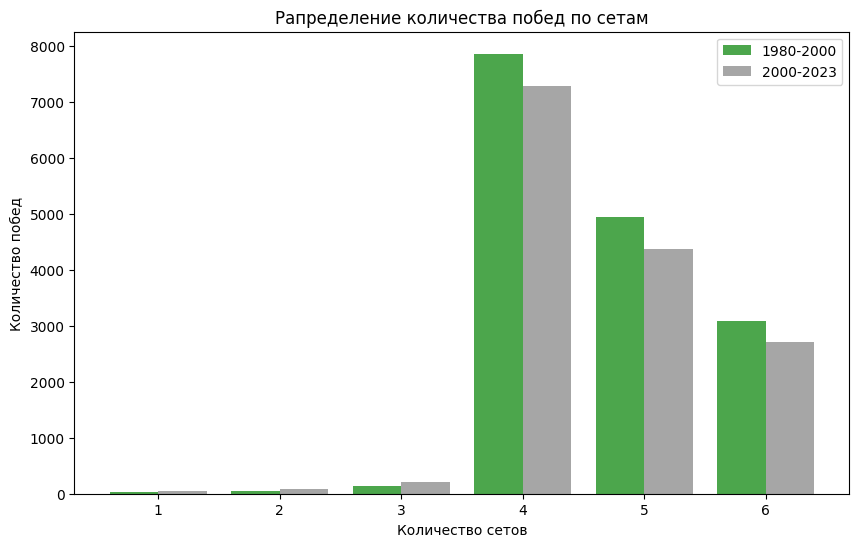

In [211]:
# Рапределение количества сетов best of 5, всего
# c фильтрацией данных по годам
task_03_1980_2001 = task_03[(task_03['year'] >= 1980) & (
    task_03['year'] <= 2001)].reset_index(drop=True)
task_03_2002_2023 = task_03[(task_03['year'] > 2001) & (
    task_03['year'] <= 2023)].reset_index(drop=True)

# Размещение баров
positions = range(1, max(task_03['sets_count']) + 2, 1)

# Построение гистограммы для каждой группы с разными цветами
plt.figure(figsize=(10, 6))
plt.bar([pos - 0.2 for pos in positions],
        task_03_1980_2001['sets_count'].value_counts().sort_index(),
        width=0.4,
        color='green',
        alpha=0.7,
        label='1980-2000')
plt.bar([pos + 0.2 for pos in positions],
        task_03_2002_2023['sets_count'].value_counts().sort_index(),
        width=0.4,
        color='gray',
        alpha=0.7,
        label='2000-2023')

plt.title('Рапределение количества побед по сетам')
plt.xlabel('Количество сетов')
plt.ylabel('Количество побед')
plt.legend()
plt.show()

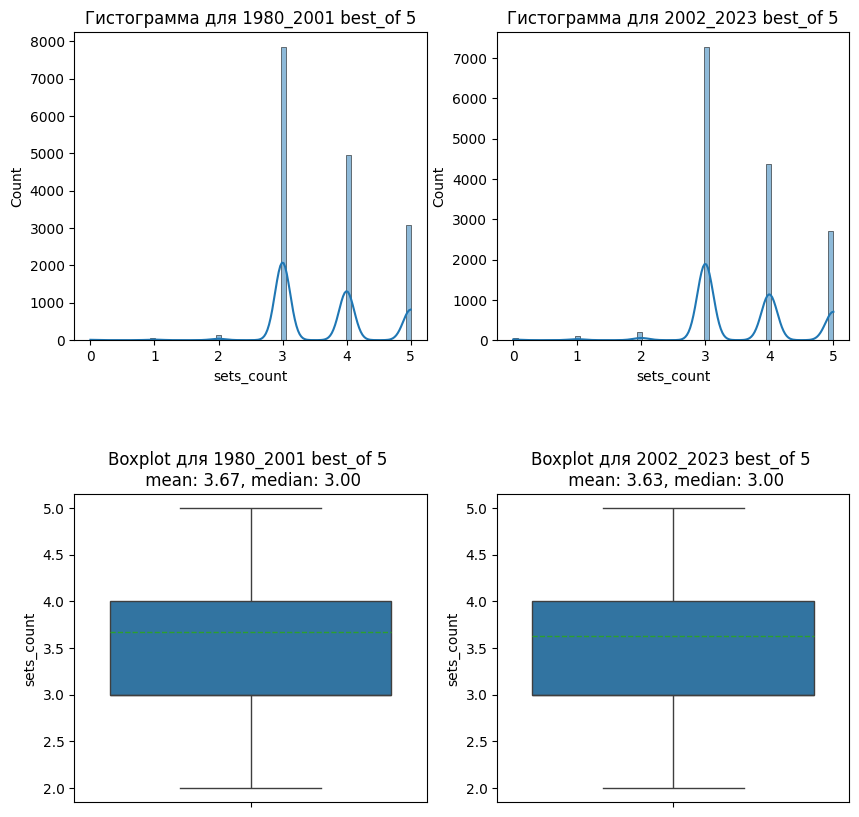

In [212]:
plot_sample_data(task_03_1980_2001.sets_count, task_03_2002_2023.sets_count,
                 title_a='1980_2001 best_of 5', title_b='2002_2023 best_of 5')

In [213]:
# Сравнение среднего количества побед

print("Среднее количество сетов для побед в периоде 1980-2001: {:.4}, общее количество партий: {}".format(task_03_1980_2001.sets_count.mean(), len(task_03_1980_2001.sets_count)))
print("Среднее количество сетов для побед в периоде 2002-2023: {:.4}, общее количество партий: {}".format(task_03_2002_2023.sets_count.mean(), len(task_03_2002_2023.sets_count)))

Среднее количество сетов для побед в периоде 1980-2001: 3.669, общее количество партий: 16109
Среднее количество сетов для побед в периоде 2002-2023: 3.629, общее количество партий: 14699


In [214]:
# Выполним тест на нормальность
shapiro_test(task_03_1980_2001.sets_count,
             task_03_2002_2023.sets_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


Несмотря на результат теста, примем, что распределение близко к нормальному на основе визуального анализа диаграмм

In [215]:
# Примененим z-test - данных достаточно (>>30), визуально данные не значительно отличаются от нормального распределения, выборки независимы
# используем alpha = 0.05
# Нулевая гипотеза: среднее значение выборки 1980_2001 меньше или равно среднему значению выборки 2002_2023
# Альтернативная гипотеза: среднее значение выборки 1980_2001 больше среднего значения выборки 2002_2023

# z-test
z_stat, p_value = ztest(task_03_1980_2001.sets_count,
                        task_03_2002_2023.sets_count, alternative='larger')

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

# Установим уровень значимости, например, 0.05
alpha = 0.05

# Проверим нулевую гипотезу
if p_value < alpha:
    print("Отвергаем нулевую гипотезу ")
else:
    print("Не отвергаем нулевую гипотезу")

Z-statistic: 4.225681445684541
P-value: 1.1910939311081864e-05
Отвергаем нулевую гипотезу 


### Вывод

Проведенный z тест позволяет утверждать - среднее первой выборки 1980_2001 больше среднего второй 2002_2023

Значит гипотеза, что ***среднее количество сетов необходимое для победы любому игроку уменьшается со временем*** верна.

***

## Задача 4

>Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис. Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

Последовательность шагов:
- Выбрать трех игроков игравших минимум 10 лет подряд
- Для каждого игрока собрать данные о сыгранных матчах (количество брейк-поинтов, полученных игроком (bpFaced), и количество отыгранных брейк-поинтов (bpSaved) в каждом матче) за период минимум 10 лет подряд.
- Для каждого игрока разделить матчи на две группы: выигранные и проигранные.
- Посчитать и сравнить долю выигранных брейк-поинтов (bpSaved / bpFaced) в каждой группе матчей за каждый год.

In [216]:
# Создание выборки к задаче
# Загрузка, выборка признаков и удаление пропусков
combined_df = pd.read_csv('combined_atp_matches.csv')
task_04 = combined_df[['year', 'winner_id', 'loser_id', 'w_bpSaved',
                       'w_bpFaced', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'loser_rank']].dropna()

# Отбор трех игроков с максимальным количеством сыгранных матчей
ids = list(task_04.winner_id.value_counts().head(3).index)

# фильтруем и группируем по игроку, вычисляем count и max, переименовываем столбцы для удобства 
(task_04[task_04['winner_id']
 .isin(ids)]
  .groupby('winner_id')
  .agg({'winner_id': 'count',  'winner_rank': 'max'})
  .rename(columns={'winner_id': 'winns_count', 'winner_rank': 'winner_rank_max'}))

task_04['game_result'] = task_04.apply(
    lambda x: 1 if x['winner_id'] in ids else 0 if x['loser_id'] in ids else None, axis=1)
task_04 = (task_04[(task_04['winner_id'].isin(ids)) |
                   (task_04['loser_id'].isin(ids))])
task_04['winned_bp'] = (task_04.apply(lambda x:
                                      round(x['w_bpSaved'] / x['w_bpFaced'] * 100, 1) if x['game_result'] == 1
                                      else round(x['l_bpSaved'] / x['l_bpFaced'] * 100, 1) if x['game_result'] == 0 else None, axis=1))
task_04 = task_04.dropna()

dataframe_summary(task_04)

Количество строк: 3344
Количество столбцов: 11
Количество пропусков в столбцах:
year           0
winner_id      0
loser_id       0
w_bpSaved      0
w_bpFaced      0
l_bpSaved      0
l_bpFaced      0
winner_rank    0
loser_rank     0
game_result    0
winned_bp      0
dtype: int64
Количество явных дубликатов: 0


In [217]:
task_04.head()

,year,winner_id,loser_id,w_bpSaved,w_bpFaced,l_bpSaved,l_bpFaced,winner_rank,loser_rank,game_result,winned_bp
115195,1998,102463,103819,1.0,3.0,1.0,5.0,88.0,702.0,0.0,20.0
116251,1998,103819,101703,1.0,1.0,4.0,8.0,878.0,45.0,1.0,100.0
116260,1998,103819,101735,4.0,4.0,8.0,10.0,878.0,43.0,1.0,100.0
116265,1998,101733,103819,4.0,5.0,7.0,10.0,20.0,878.0,0.0,70.0
116273,1998,101736,103819,1.0,2.0,4.0,8.0,8.0,396.0,0.0,50.0


Для отбора временного окна, где для каждого игрока есть данные и о победах и опоражениях графически посмотрим на распределение побед и поражений

Text(0, 0.5, 'Количество матчей с победой')

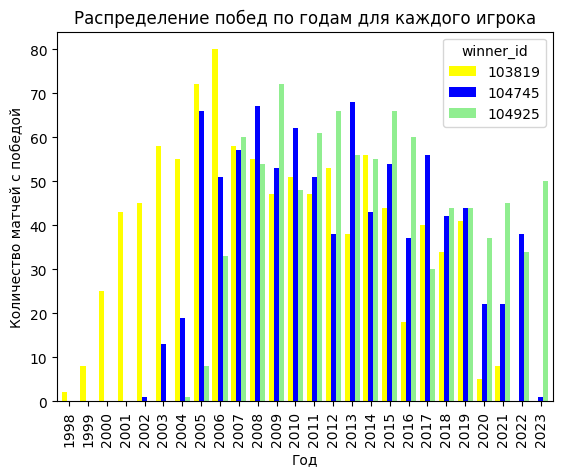

In [218]:
win_plot = task_04[task_04.game_result == 1].groupby(['year', 'winner_id']).size().unstack(
).plot(kind='bar', stacked=False, width=0.8, color=['yellow', 'blue', 'lightgreen'])
win_plot.set_title('Распределение побед по годам для каждого игрока')
win_plot.set_xlabel('Год')
win_plot.set_ylabel('Количество матчей с победой')

Text(0, 0.5, 'Количество матчей с поражением')

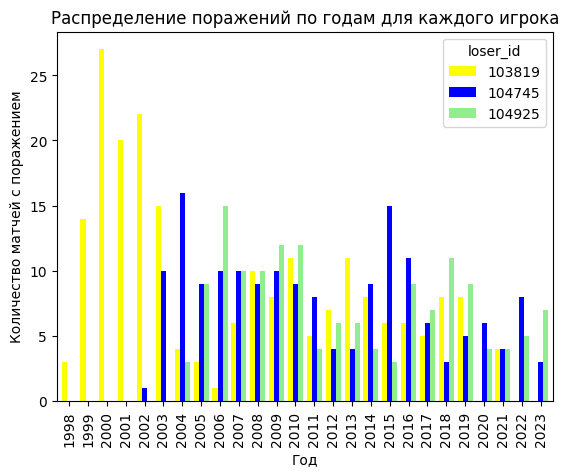

In [219]:
lose_plot = task_04[task_04.game_result == 0].groupby(['year', 'loser_id']).size().unstack().plot(kind='bar', stacked=False, width=0.8, color=['yellow', 'blue', 'lightgreen'])
lose_plot.set_title('Распределение поражений по годам для каждого игрока')
lose_plot.set_xlabel('Год')
lose_plot.set_ylabel('Количество матчей с поражением')

In [220]:
# выбираем  временное окно 2005-2015
task_04 = task_04[(task_04['year'] >= 2005) & (task_04['year'] <= 2015)]
dataframe_summary(task_04)

Количество строк: 2054
Количество столбцов: 11
Количество пропусков в столбцах:
year           0
winner_id      0
loser_id       0
w_bpSaved      0
w_bpFaced      0
l_bpSaved      0
l_bpFaced      0
winner_rank    0
loser_rank     0
game_result    0
winned_bp      0
dtype: int64
Количество явных дубликатов: 0


In [221]:
# Сбор общей статистики по игрокам
result = []
for gamer_id in ids:
    for game_result in task_04.game_result.unique():
        df = (task_04[(task_04.game_result == game_result) &
                      ((task_04.winner_id == gamer_id) | (task_04.loser_id == gamer_id))])
        df = df.groupby(['year'])['winned_bp'].mean().reset_index()
        # Set the column name to "<gamer_id>_<result>"
        column_name = f"{gamer_id}_{game_result}"
        df.rename(columns={'winned_bp': column_name}, inplace=True)
        df.set_index('year', inplace=True)
        result.append(df)

# Concatenate the result dataframes on the columns
task_04_result_df = pd.concat(result, axis=1)
task_04_result_df

,103819_1.0,103819_0.0,104925_1.0,104925_0.0,104745_1.0,104745_0.0
year,,,,,,
2005,64.243836,40.300000,67.000000,54.100000,62.619403,50.466667
2006,66.363095,50.000000,61.560000,52.073333,70.866038,50.320000
2007,64.980328,52.983333,69.075000,56.270000,70.122581,56.760000
2008,71.783333,58.490000,67.315000,59.780000,64.375362,49.877778
2009,74.607843,52.262500,65.311688,57.783333,66.294643,54.110000
2010,70.996226,54.245455,67.857407,56.100000,65.139683,48.200000
2011,65.290741,61.840000,65.045161,36.925000,63.628070,47.150000
2012,74.124561,46.742857,66.338571,49.716667,72.132500,38.750000
2013,69.852273,60.663636,65.454237,61.050000,69.810000,69.825000


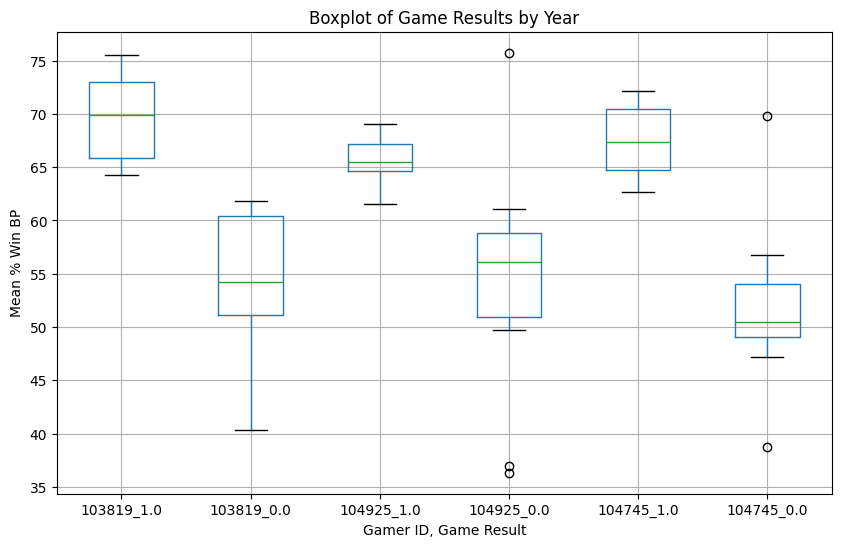

In [222]:
# Создание боксплотов
plt.figure(figsize=(10, 6))
boxplot = task_04_result_df.boxplot()

# Настройка заголовка и осей
plt.title('Boxplot of Game Results by Year')
plt.xlabel('Gamer ID, Game Result')
plt.ylabel('Mean % Win BP')
plt.show()

Для того чтобы выяснить, независимо ли распределение метрики winned_bp по годам для каждого игрока, можно использовать следующие статистические тесты:

* Для одного игрока (внутригрупповой анализ):

Чтобы проверить независимость распределения winned_bp по годам для победных и проигранных матчей одного игрока, можно использовать `двусторонний хи-квадрат тест независимости`. Этот тест сравнит частоты winned_bp для победных и проигранных матчей по каждому году.

* Между игроками (межгрупповой анализ):
Для сравнения средних значений метрики winned_bp между игроками для выигранных матчей и отдельно для проигранных матчей можно использовать `однофакторный ANOVA тест`, если предполагается, что данные распределены нормально и дисперсии равны.

Если данные не соответствуют предпосылкам нормальности или гомоскедастичности, следует использовать непараметрический тест, например, Краскела-Уоллиса.

Перед применением статистических тестов, необходимо проверить предпосылки:

`Нормальность распределения`: тест Шапиро-Уилка.

`Равенство дисперсий`: тест Левена или Бартлетта.

После проверки предпосылок выбираем соответствующий статистический тест. Если предпосылки не выполняются, используем соответствующие непараметрические тесты.

1. Проверить предположение о независимости распределений по годам для каждого игрока с помощью теста Краскела-Уоллиса. Это непараметрический аналог одностороннего дисперсионного анализа (ANOVA), который не требует предположения о нормальном распределении данных. Нулевая гипотеза: распределения по годам идентичны для каждого игрока, альтернативная: по крайней мере одно распределение отличается от остальных.

In [223]:
H0 = 'распределения по годам идентичны для каждого игрока'
H1 = 'по крайней мере одно распределение отличается от остальных'


def run_kruskal_test(player_id, task_04_result_df):
    statistic, p_value = kruskal(
        task_04_result_df[f'{player_id}_1.0'], task_04_result_df[f'{player_id}_0.0'])
    result = f"Отвергаем нулевую гипотезу. Принимаем гипотезу {H1}" if p_value < 0.05 else f"Принимаем альтернативную гипотезу {H1}"
    print(f"Для игрока {player_id}: {result}")


for player in ids:
    run_kruskal_test(player, task_04_result_df)

Для игрока 103819: Отвергаем нулевую гипотезу. Принимаем гипотезу по крайней мере одно распределение отличается от остальных
Для игрока 104925: Отвергаем нулевую гипотезу. Принимаем гипотезу по крайней мере одно распределение отличается от остальных
Для игрока 104745: Отвергаем нулевую гипотезу. Принимаем гипотезу по крайней мере одно распределение отличается от остальных


2. Для сравнения долей выигранных брейк-поинтов между игроками можно использовать тест Краскела-Уоллиса для независимых выборок. Проверяем гипотезу о том, что средние доли выигранных брейк-поинтов одинаковы для всех игроков, отдельно для проигранных и выигранных матчей. Если обнаруживается значимое различие, то можно провести попарные сравнения с помощью теста Манна-Уитни с поправкой Бонферрони.

In [224]:
def run_kruskal_wallis_test(task_04_result_df):

    for player in ids:
        player_data = task_04_result_df[[f'{player}_1.0', f'{player}_0.0']]
        statistic, p_value = kruskal(
            player_data[f'{player}_1.0'], player_data[f'{player}_0.0'])
        result = "Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны." if p_value < 0.05 else "Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы."
        print(f"Для игрока {player}: {result}")

    # Попарные сравнения с помощью теста Манна-Уитни с поправкой Бонферрони
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            player1_data = task_04_result_df[[
                f'{ids[i]}_1.0', f'{ids[i]}_0.0']]
            player2_data = task_04_result_df[[
                f'{ids[j]}_1.0', f'{ids[j]}_0.0']]
            _, p_value = mannwhitneyu(
                player1_data[f'{ids[i]}_1.0'], player2_data[f'{ids[j]}_1.0'], alternative='two-sided')
            adjusted_p_value = p_value * \
                len(ids) * (len(ids) - 1) / 2  # Поправка Бонферрони
            comparison_result = "Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны." if adjusted_p_value < 0.05 else "Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы."
            print(
                f"Сравнение для игроков {ids[i]} и {ids[j]}: {comparison_result}")


run_kruskal_wallis_test(task_04_result_df)

Для игрока 103819: Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны.
Для игрока 104925: Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны.
Для игрока 104745: Отвергаем нулевую гипотезу: средние доли выигранных брейк-поинтов различны.
Сравнение для игроков 103819 и 104925: Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы.
Сравнение для игроков 103819 и 104745: Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы.
Сравнение для игроков 104925 и 104745: Принимаем нулевую гипотезу: средние доли выигранных брейк-поинтов одинаковы.


### Выводы
1. Распределения по годам (по победным и по проигранным матчам) <b>являются независимыми</b> для каждого из игроков.
2. <b>Нет статистически значимой разницы</b> в средних для проигранных и выигранных матчей попарно между всеми игроками.

***

## Задача 5

>У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре. Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.

Шаги:

1. Создать новый признак, отражающий долю выигранных брейк-поинтов для каждого игрока в матче по формуле:  
Доля выигранных брейк-поинтов = (wbpSaved + lbpSaved) / (wbpFaced + lbpFaced)

2. Разделить выборку на две группы: матчи, где игроки выиграли брейк-поинты больше или равно медиане, и матчи, где они выиграли меньше медианы.

3. Создать таблицу сопряжённости, где строки - доля выигранных брейк-поинтов (выше/ниже медианы), а столбцы — исход матча (победа/поражение).

Сбор данных о брейк-поинтах (колонки bpFaced и bpSaved) за 10 лет подряд (отдельно для победных и проигранных матчей) и расчет доли выигранных брейк-поинтов (bpSaved / bpFaced) для каждого игрока (отдельно для победных и проигранных матчей по годам) *выполняется как в задании 4*.

In [102]:
# Создание выборки для задачи
combined_df = pd.read_csv('combined_atp_matches.csv')

# Выбор определенных столбцов и удаление строк с отсутствующими значениями
task_05 = combined_df[['year', 'winner_id', 'loser_id',
                       'w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced']].dropna()

# Вычисление показателей соотношения брейк-поинтов
task_05['bp_ratio_winner'] = round(
    (task_05['w_bpSaved'] / task_05['w_bpFaced'] * 100), 1)
task_05['bp_ratio_loser'] = round(
    (task_05['l_bpSaved'] / task_05['l_bpFaced'] * 100), 1)

# Удаление строк с отсутствующими значениями
task_05 = task_05.dropna()

# Создание DataFrame для победителей и проигравших
winners = task_05[['year', 'winner_id', 'bp_ratio_winner']].rename(
    columns={'winner_id': 'id', 'bp_ratio_winner': 'bp_ratio'})
losers = task_05[['year', 'loser_id', 'bp_ratio_loser']].rename(
    columns={'loser_id': 'id', 'bp_ratio_loser': 'bp_ratio'})

# Добавление столбца 'result'
winners['result'] = 1
losers['result'] = 0

# Удаление дублирующихся строк
task_05 = task_05.drop_duplicates()

# Объединение DataFrame
task_05 = pd.concat([winners, losers], ignore_index=True)
task_05 = task_05.drop_duplicates()

# Вычисление медианы показателя брейк-поинтов для победителей и проигравших
losers_median = losers.bp_ratio.median()
winners_median = winners.bp_ratio.median()

# Создание столбца 'breakpoints_level'
task_05['breakpoints_level'] = (task_05
                                .apply(lambda x:
                                       'more median' if (x['bp_ratio'] >= winners_median and x['result'] == 1) else
                                       'less median' if (x['bp_ratio'] < winners_median and x['result'] == 1) else
                                       'more median' if (x['bp_ratio'] >= losers_median and x['result'] == 0) else
                                       'less median' if (x['bp_ratio'] < losers_median and x['result'] == 0) else '', axis=1))

dataframe_summary(task_05)  # Отображение информации о DataFrame

Количество строк: 114879
Количество столбцов: 5
Количество пропусков в столбцах:
year                 0
id                   0
bp_ratio             0
result               0
breakpoints_level    0
dtype: int64
Количество явных дубликатов: 0


In [91]:
task_05.head()

,year,id,bp_ratio,result,breakpoints_level
0,1991,101723,50.0,1,less median
1,1991,100946,90.0,1,more median
2,1991,101234,100.0,1,more median
3,1991,101889,100.0,1,more median
4,1991,101274,87.5,1,more median


In [92]:
print(winners_median, losers_median)

66.7 53.3


In [93]:
task_05.groupby('result')['breakpoints_level'].value_counts().unstack()

breakpoints_level,less median,more median
result,,
0,30556,35615
1,22003,26705


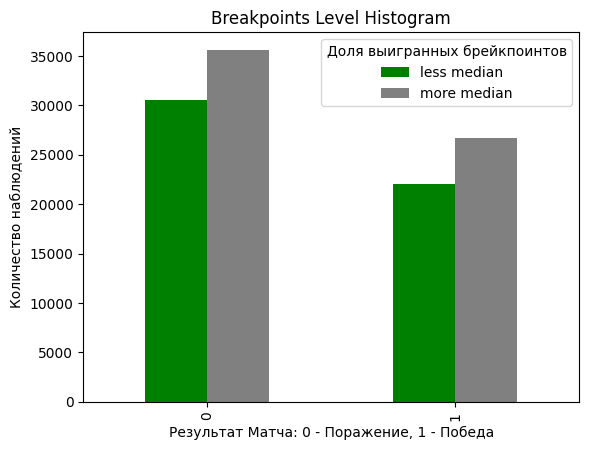

In [98]:
count_of_games = task_05.groupby(
    'result')['breakpoints_level'].value_counts().unstack().plot(kind='bar', color=['green', 'gray'])
count_of_games.set_title('Breakpoints Level Histogram')
plt.xlabel('Результат Матча: 0 - Поражение, 1 - Победа')
plt.ylabel('Количество наблюдений')
plt.legend(title='Доля выигранных брейкпоинтов')
plt.show()

In [103]:
count_of_games = task_05.groupby(
    'result')['breakpoints_level'].value_counts().unstack()
count_of_games

breakpoints_level,less median,more median
result,,
0,30556,35615
1,22003,26705


In [104]:
count_of_games['less median'][0]

30556

**Обоснование выбора теста**

Парный Z-тест используется для сравнения средних значений двух связанных выборок. В данном случае есть две выборки (значения "breakpoints_level" для двух разных медианных значений "less median" и "more median") и можно использовать парный Z-тест для определения, есть ли статистически значимая разница между этими двумя значениями.

In [106]:
# нулевая и альтернативная гипотезы
H0 = 'Соотношения долей брейкпоинтов (больше / меньше медианы) -  в группах 0 и 1 равны'
H1 = 'Доля брейкпоинтов больше медианы -  в группе 0 выше, чем в группе 1'
alpha = 0.05  # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=count_of_games['less median'],
    nobs=count_of_games['more median'],
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.0
Отвергаем нулевую гипотезу. Соотношения долей брейкпоинтов (больше / меньше медианы) -  в группах 0 и 1 равны
Альтернативная гипотеза. H1: Доля брейкпоинтов больше медианы -  в группе 0 выше, чем в группе 1


### Вывод

Доля выигранных брейк-поинтов ***связана*** с вероятностью победить в игре.

***